# Setup

In [1]:
%load_ext autoreload
# reload modules automatically before each cell
%autoreload 2

%config IPCompleter.evaluation='unsafe'

In [2]:
from pyiron_workflow import Workflow as workflow

In [3]:
import requests
import os
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" # if not already set by the OS; doesn't hurt

# fixes a bug in SPARQLwrapper
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# importing pandas to make printed dataframes prettier
import pandas as pd, hashlib
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.width', 200)

from pmd_demo_tools import mesh_tools, sparql_tools
from pmd_demo_tools.query_collection import S355queries
S355queries = S355queries()

# Node definitions

In [4]:
import json

@workflow.wrap.as_function_node("partners")
def populate_mesh_registry(token_file_path: str | None) -> mesh_tools.RecursiveNamespace:
    # read in all servers on the mesh
    partners = mesh_tools.mesh_namespace_grouped_by_company()

    # attach hosted services
    _ = mesh_tools.attach_services_in_place(partners)
    
    if token_file_path is not None:
        with open(token_file_path, "r", encoding="utf-8") as f:
            tokens = json.load(f, object_hook=mesh_tools.namespace_object_hook())

        mesh_tools.attach_tokens_to_partners(partners, tokens, overwrite=True, warn_missing=False)

    return partners

In [5]:
@workflow.wrap.as_function_node("partners")
def reduce_mesh_registry(partners_in: mesh_tools.RecursiveNamespace,
                        selection: list[str]) -> mesh_tools.RecursiveNamespace:
    partners = mesh_tools.select_toplevel(partners_in, selection, deepcopy=True)
    return partners

In [6]:
@workflow.wrap.as_dataclass_node
class MeshQueryResponse:
    results_rns: mesh_tools.RecursiveNamespace
    query: sparql_tools.SparqlQuery

@workflow.wrap.as_function_node("MeshQueryResponse")
def query_datasets_on_mesh(partners: mesh_tools.RecursiveNamespace,
                           query: sparql_tools.SparqlQuery,
                           datasets: list[str] | None = None,
                           print_to_screen: bool = False) -> MeshQueryResponse:
    results = sparql_tools.federated_query(partners=partners, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=print_to_screen)
    results_rns = mesh_tools.RecursiveNamespace(**results)
    return MeshQueryResponse(results_rns=results_rns,
                             query=query)


In [7]:
import numpy as np
from scipy.optimize import curve_fit

@workflow.wrap.as_dataclass_node
class ElasticModulusCalculation:
    elastic_modulus: float
    variance_elastic_modulus: float
    stress_offset: float
    variance_stress_offset: float
    elastic_strain_limit: float
    elastic_limit_index: int

def lin_func(x,a,b):
        return a*x+b

@workflow.wrap.as_function_node("ElacsticModulusCalculation")
def calc_elastic_modulus(stress: np.array, 
                         strain: np.array, 
                         elastic_strain_limit: float = 0.001,
                         elastic_modulus_guess: float = 200.0,
                         stress_offset_guess: float = -0.1
                        ) -> ElasticModulusCalculation:
 
    strain = np.asarray(strain)
    stress = np.asarray(stress)

    elastic_limit_index = 0
    # avoid IndexError if all strain <= elastic_strain_limit
    while (
        elastic_limit_index < len(strain) - 1
        and strain[elastic_limit_index] <= elastic_strain_limit
    ):
        elastic_limit_index += 1

    if elastic_limit_index < 1:
        raise ValueError(
            f"Not enough points in elastic region (strain <= {elastic_strain_limit})."
        )

    popt, pcov = curve_fit(
        lin_func,
        strain[:elastic_limit_index + 1],
        stress[:elastic_limit_index + 1],
        p0=np.asarray([400000.0, -1000000.0]),
    )

    elastic_modulus = popt[0]
    stress_offset = popt[1]
    variance_elastic_modulus = pcov[0, 0]
    variance_stress_offset = pcov[1, 1]
    elastic_strain_limit_measured = strain[elastic_limit_index]

    return ElasticModulusCalculation(
        elastic_modulus,
        variance_elastic_modulus,
        stress_offset,
        variance_stress_offset,
        elastic_strain_limit_measured,
        elastic_limit_index,
    )

In [8]:
@workflow.wrap.as_dataclass_node
class OffsetYieldCalculation:
    offset_strain: float
    yield_stress: float
    yield_strain: float

@workflow.wrap.as_function_node("OffsetYieldCalculation")
def offset_yield_calculation(stress: np.array,
                             strain: np.array,
                             elastic_modulus: float | None = None,
                             offset_strain: float = 0.002
                            ) -> OffsetYieldCalculation:
    if elastic_modulus is None:
        E = calc_elastic_modulus(stress=stress, strain=strain)
        elastic_modulus = E.elastic_modulus
        
    offset_elastic_line = elastic_modulus * (strain - offset_strain)
    # difference between curves
    delta = stress - offset_elastic_line

    # find indices where sign changes (curve intersection)
    sign = np.sign(delta)
    # treat exact zeros as positive to avoid double crossings
    sign[sign == 0] = 1.0
    crossings = np.where(np.diff(sign) != 0)[0]

    if len(crossings) == 0:
        # fallback: closest point if we never actually cross
        arg = np.argmin(np.abs(delta))
        yield_strain = strain[arg]
        yield_stress = stress[arg]
    else:
        i = crossings[0]  # first crossing
        # linear interpolation in [i, i+1] on delta = 0
        x0, x1 = strain[i], strain[i + 1]
        d0, d1 = delta[i], delta[i + 1]

        # avoid division by zero if two delta’s are equal (very degenerate)
        if d1 == d0:
            yield_strain = x0
            yield_stress = stress[i]
        else:
            # strain at intersection (delta == 0)
            yield_strain = x0 - d0 * (x1 - x0) / (d1 - d0)

            # linearly interpolate stress at that strain
            s0, s1 = stress[i], stress[i + 1]
            yield_stress = s0 + (s1 - s0) * (yield_strain - x0) / (x1 - x0)

    return OffsetYieldCalculation(
        offset_strain=offset_strain,
        yield_stress=yield_stress,
        yield_strain=yield_strain,
    )

# Assign queries

In [9]:
orientation_query = S355queries.orientation()
csv_url_query = S355queries.csv_url()
csv_column_query = S355queries.csv_columns()
primary_data_query = S355queries.primary_data()


# Wrap analisis for a single specimen

In [20]:
@workflow.wrap.as_dataclass_node
class TensileTestResults:
    elastic_modulus_calc: ElasticModulusCalculation
    offset_yield_calc: OffsetYieldCalculation
    stress: np.array
    strain: np.array
    cross_section: float | None
    uri: str | None
    rolling_direction: str | None
    raw_data_url: str | None
    specimen_id: str | None
    query_timestamp: pandas._libs.tslibs.timestamps.Timestamp | None

@workflow.wrap.as_macro_node("TensileTestResults")
def tensile_test_analisis(stress: np.array, 
                          strain: np.array, 
                          elastic_strain_limit: float = 0.001,
                          elastic_modulus_guess: float = 200.0,
                          stress_offset_guess: float = -0.1,
                          offset_strain: float = 0.002
                         ) -> TensileTestResults:
    print("uff")
    return TensileTestResults(
        elastic_modulus_calc = self.elastic_modulus_calc,
        offset_yield_calc = self.offset_yield_calc,
        stress = self.stress,
        strain = self.strain,
        cross_section = self.cross_section,
        uri = self.uri,
        rolling_direction = self.rolling_direction,
        raw_data_url = self.raw_data_url,
        specimen_id = self.specimen_id,
        query_timestamp = self.timestamp,
    )

# Workflow

In [10]:
populate_registry = populate_mesh_registry()
reduce_registry = reduce_mesh_registry()
query_on_mesh = query_datasets_on_mesh()

In [11]:
wf = workflow("S355_tensile_test_analisis")

token_file_path = "../secrets/tokens.json"
wf.populate_registry = populate_mesh_registry()
wf.populate_registry.inputs.token_file_path = token_file_path

In [12]:
wf.reduce_registry = reduce_mesh_registry()
wf.reduce_registry.inputs.partners_in = wf.populate_registry.outputs.partners

selection = ["Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT", "Fraunhofer_IWM", "KIT"]
wf.reduce_registry.inputs.selection = selection

In [13]:
datasets = ["pmdco2_tto_example_parallel", "pmdco2_tto_example_perpendicular","pmdco2_tto_example_diagonal"]

In [14]:
wf.query_cut_orientation = query_datasets_on_mesh()
wf.query_cut_orientation.inputs.partners = wf.reduce_registry.outputs.partners
wf.query_cut_orientation.inputs.query = orientation_query
wf.query_cut_orientation.inputs.datasets = datasets

In [15]:
wf.query_csv_url = query_datasets_on_mesh()
wf.query_csv_url.inputs.partners = wf.reduce_registry.outputs.partners
wf.query_csv_url.inputs.query = csv_url_query
wf.query_csv_url.inputs.datasets = datasets

In [16]:
wf.query_csv_columns = query_datasets_on_mesh()
wf.query_csv_columns.inputs.partners = wf.reduce_registry.outputs.partners
wf.query_csv_columns.inputs.query = csv_column_query
wf.query_csv_columns.inputs.datasets = datasets

In [17]:
wf.query_primary_data = query_datasets_on_mesh()
wf.query_primary_data.inputs.partners = wf.reduce_registry.outputs.partners
wf.query_primary_data.inputs.query = primary_data_query
wf.query_primary_data.inputs.datasets = datasets

/home/jovyan/work/pmd-demonstrator/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/mesh_tools.py:606: UserWarning: Failed fetching services for glassomer.pmd.internal: 500 Server Error: Internal Server Error for url: http://mesh-listing.c.pmd.internal/api/v1/pmds/glassomer.pmd.internal.
  warnings.warn(f"Failed fetching services for {zone}: {e}.", category=UserWarning)


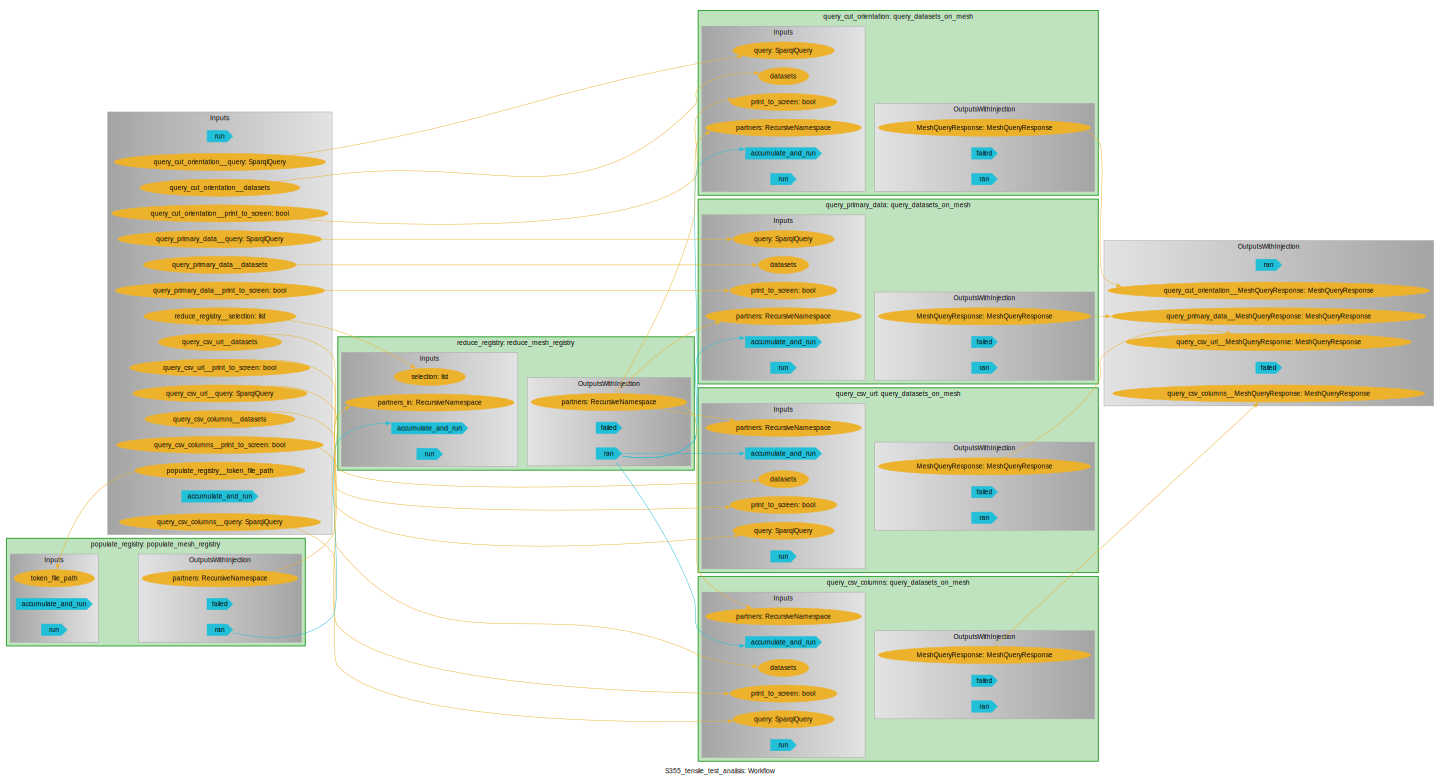

In [18]:
wf.run()
wf.draw(size=(20,40))